###  Implémentez un modèle de scoring

In [44]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import cufflinks as cf
cf.go_offline()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

In [2]:
list_data = ["sample_submission", "application_test", "application_train", "bureau_balance", "bureau",
             "previous_application", "credit_card_balance", "POS_CASH_balance", "installments_payments"]


for i in list_data:
    print(i+".csv")
    globals()[i] = pd.read_csv(i+".csv")

sample_submission.csv
application_test.csv
application_train.csv
bureau_balance.csv
bureau.csv
previous_application.csv
credit_card_balance.csv
POS_CASH_balance.csv
installments_payments.csv


In [5]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
for i in list_data:
    print("pour", i, "on a ", globals()[i].shape)

pour sample_submission on a  (48744, 2)
pour application_test on a  (48744, 121)
pour application_train on a  (307511, 122)
pour bureau_balance on a  (27299925, 3)
pour bureau on a  (1716428, 17)
pour previous_application on a  (1670214, 37)
pour credit_card_balance on a  (3840312, 23)
pour POS_CASH_balance on a  (10001358, 8)
pour installments_payments on a  (13605401, 8)


In [6]:
for i in list_data:
    globals()["columns_%s" % i] = globals()[i].columns

In [7]:
set(columns_application_train)-set(columns_application_test)

{'TARGET'}

In [8]:
sample_submission

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


Les fichiers application_test et sample_submission peuvent être mise de côté. Il reste 7 fichiers à travailler  

In [9]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [10]:
bureau_balance["STATUS"].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [11]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
application_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

# Analyse missing data

In [47]:
def ana_missing_data(df):    
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data=missing_data[missing_data["Total"]>0].head(10)
    return missing_data

In [14]:
# checking missing  in application_train
ana_missing_data(application_train)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


In [15]:
# checking missing data previous_application
ana_missing_data(previous_application)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


In [16]:
# checking missing data credit_card_balance
ana_missing_data(credit_card_balance)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208


In [17]:
# checking missing data bureau
ana_missing_data(bureau)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757


In [18]:
# checking missing data POS_CASH_balance
ana_missing_data(POS_CASH_balance)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675


In [19]:
# checking missing data installments_payments
ana_missing_data(installments_payments)

,Total,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352


# Analyse Exploratoire

In [20]:
## Def

In [23]:
def ana_courbe(List, Name, Data):
    
    if Data =="Application":
        df=application_train
    
    elif Data =="previous":
        df=previous_application
    
    
    SIZE=22
    for i,j  in zip(List, Name):
        fig = plt.figure(constrained_layout=True, figsize=[12,7])
        fig.suptitle("Analyse univariée "+j, size=22, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])
        ax_box = fig.add_subplot(spec[0, :])
        ax_hist = fig.add_subplot(spec[1, :])
        sns.boxplot(df[i], ax=ax_box)
        sns.histplot(x=df[i], bins=25,  kde=True, stat="density", ax=ax_hist)

        plt.rc('axes', labelsize=SIZE) 
        plt.rc('xtick', labelsize=SIZE)
        plt.rc('ytick', labelsize=SIZE) 
        plt.rc('legend', fontsize=SIZE)
        plt.savefig("fig/"+Data+"_Ana_univariee_"+i+".png", bbox_inches='tight',format='png')
        
    return


def ana_cercle(List, Name, Data):
    if Data =="Application":
        df=application_train
    
    elif Data =="previous":
        df=previous_application    
    
    
    SIZE=22
    for i,j in zip(List, Name):
        temp = df[i].value_counts()
        df_temp=pd.DataFrame({'labels':temp.index, 'values':temp.values})
        df_temp.iplot(kind='pie',labels='labels',values='values', title=j, hole = 0.5)
        plt.rc('axes', labelsize=SIZE) 
        plt.rc('xtick', labelsize=SIZE)
        plt.rc('ytick', labelsize=SIZE) 
        plt.rc('legend', fontsize=SIZE)
        plt.savefig("fig/"+Data+"_pie_"+i+".png", bbox_inches='tight',format='png')
    return
        

def ana_bar(List, Name, Data):    
    if Data =="Application":
        df=application_train
    
    elif Data =="previous":
        df=previous_application
        
    SIZE=15
    for i, j in zip(List, Name):
        fig = plt.subplots(figsize=(9, 6))
        sns.barplot(
            x=df[i].value_counts().index,
            y=df[i].value_counts(normalize=True),
        )
        plt.xlabel("Name contract", size=15)
        plt.xticks(rotation=90)
        plt.ylabel("%", size=15)
        plt.title(j, size=17)
        plt.rc('axes', labelsize=SIZE) 
        plt.rc('xtick', labelsize=SIZE)
        plt.rc('ytick', labelsize=SIZE) 
        plt.rc('legend', fontsize=SIZE)
        plt.tight_layout()
        plt.savefig("fig/"+Data+"_bar_"+i+".png")

        plt.show() 
    return
    

In [25]:
application_train["DAYS_BIRTH"]

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64

/home/bdiallo/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/bdiallo/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/bdiallo/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/bdiallo/miniconda3/lib/python3.8/site-pa

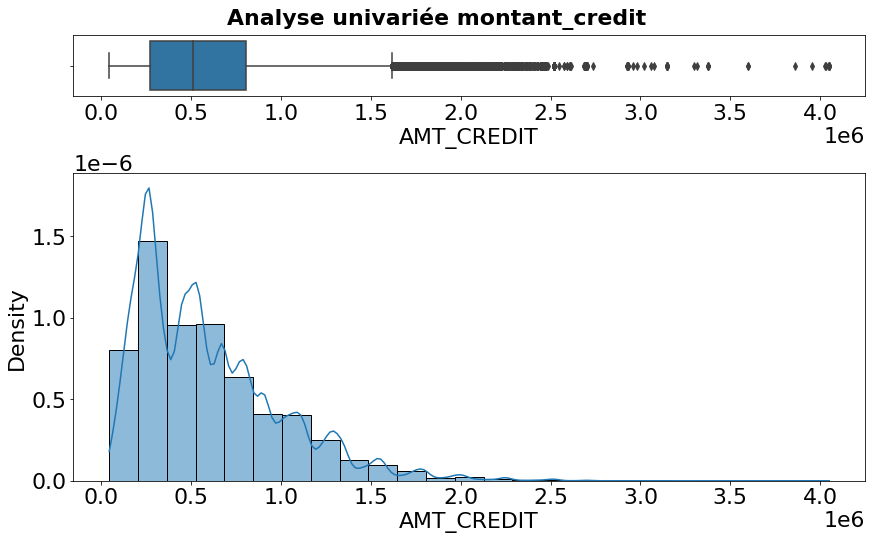

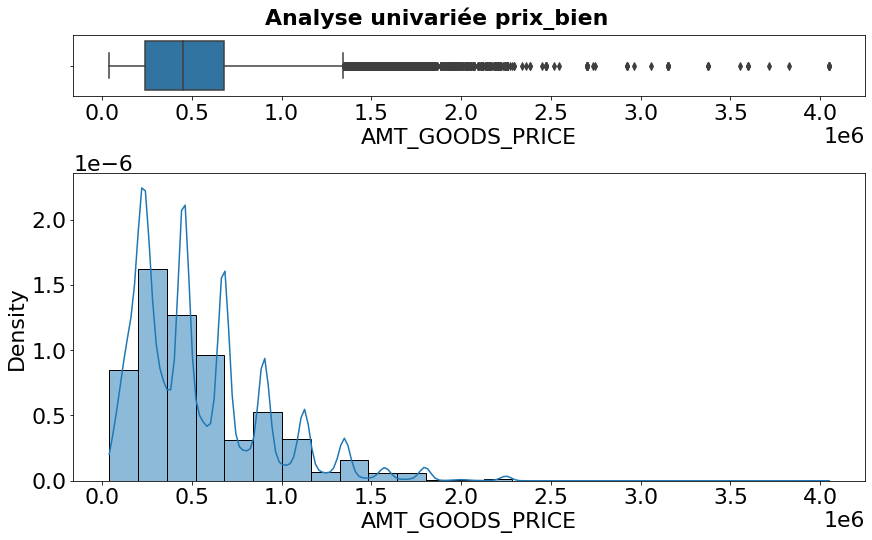

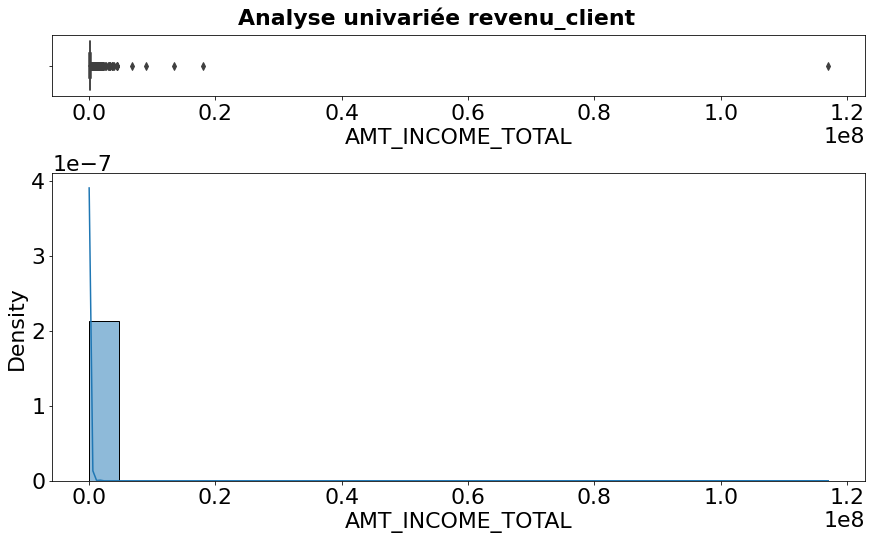

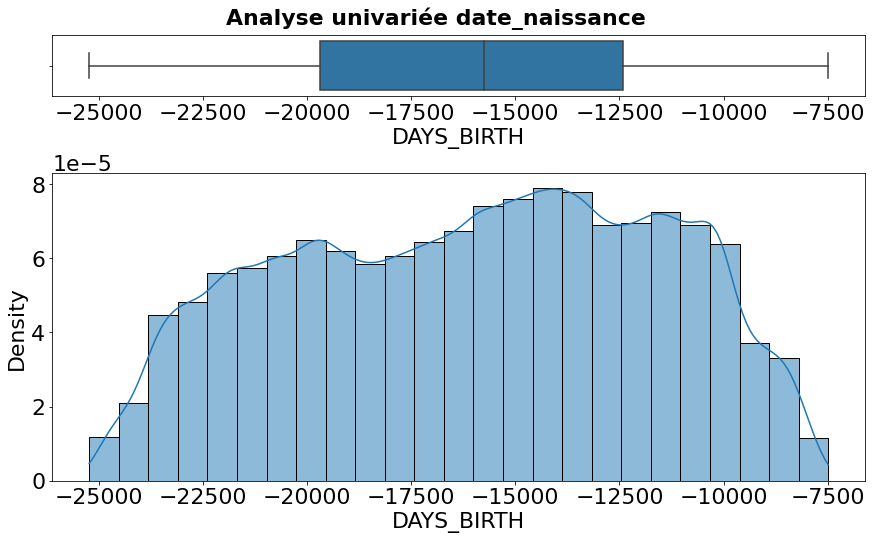

In [26]:
List_courbes=["AMT_CREDIT", "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL","DAYS_BIRTH"]
Name_courbes=["montant_credit", "prix_bien", "revenu_client", "date_naissance"]

ana_courbe(List_courbes, Name_courbes, "Application")

In [23]:
list_cercle=["NAME_FAMILY_STATUS", "NAME_EDUCATION_TYPE", "NAME_INCOME_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
Name_cercle=["Status du demandeur", "Niveau d'étude du demandeur",
            "Revenu du demandeur", "Bien posssédé (voiture) du demandeur", "Bien posssédé (maison) du demandeur"]

ana_cercle(list_cercle, Name_cercle, "Application")

<Figure size 432x288 with 0 Axes>

In [35]:
application_train["NAME_CONTRACT_TYPE"].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

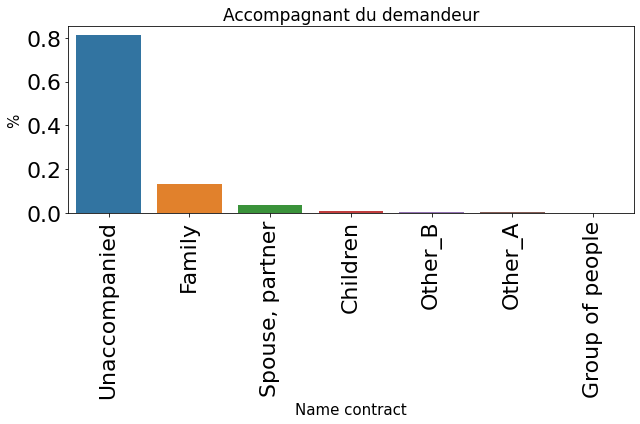

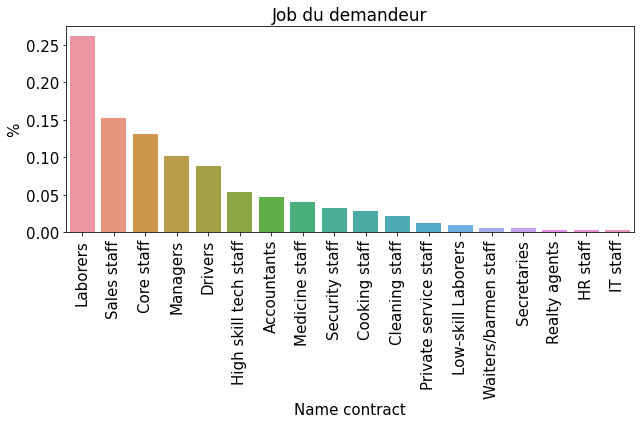

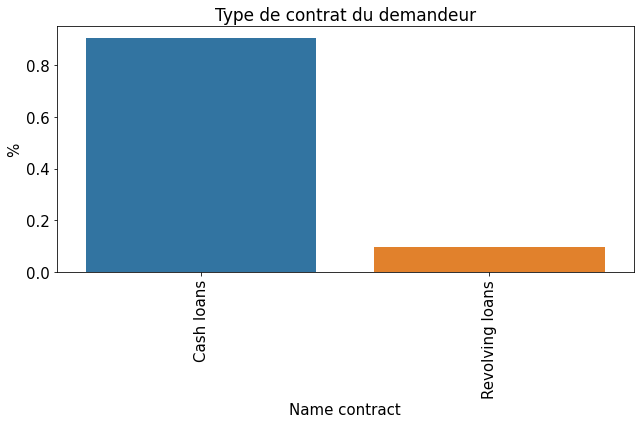

In [24]:
list_bar=["NAME_TYPE_SUITE", "OCCUPATION_TYPE","NAME_CONTRACT_TYPE"]
Name_bar=["Accompagnant du demandeur", "Job du demandeur", "Type de contrat du demandeur"]

ana_bar(list_bar, Name_bar, "Application")

<AxesSubplot:ylabel='TARGET'>

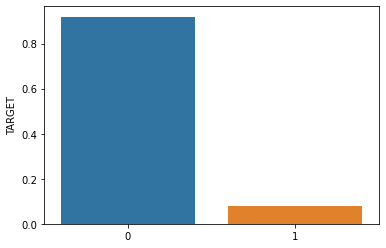

In [10]:
sns.barplot(
    x=application_train["TARGET"].value_counts().index,
    y=application_train["TARGET"].value_counts(normalize=True),
)

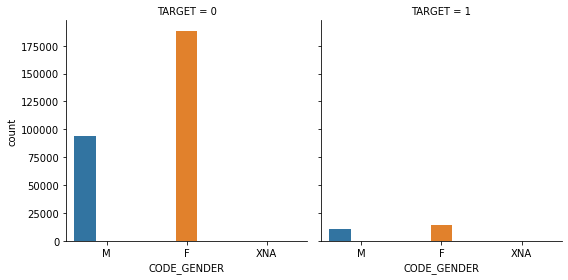

In [21]:
sns.catplot(x="CODE_GENDER", col="TARGET", kind="count", data=application_train, hue="CODE_GENDER",
           height=4)


In [27]:
corr = application_train.corr()["TARGET"].sort_values()
top_negative_corr = corr.head(20)
top_positive_corr = corr.tail(20)
print("top negative corrolation: \n", top_negative_corr)
print("top positive corrolations: \n", top_positive_corr)

top negative corrolation: 
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
FLOORSMIN_MEDI               -0.033394
LIVINGAREA_AVG               -0.032997
LIVINGAREA_MEDI              -0.032739
FLOORSMIN_MODE               -0.032698
TOTALAREA_MODE               -0.032596
ELEVATORS_MODE               -0.032131
LIVINGAREA_MODE              -0.030685
AMT_CREDIT                   -0.030369
Name: TARGET, dtype: float64
top positive corrolations: 
 OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT

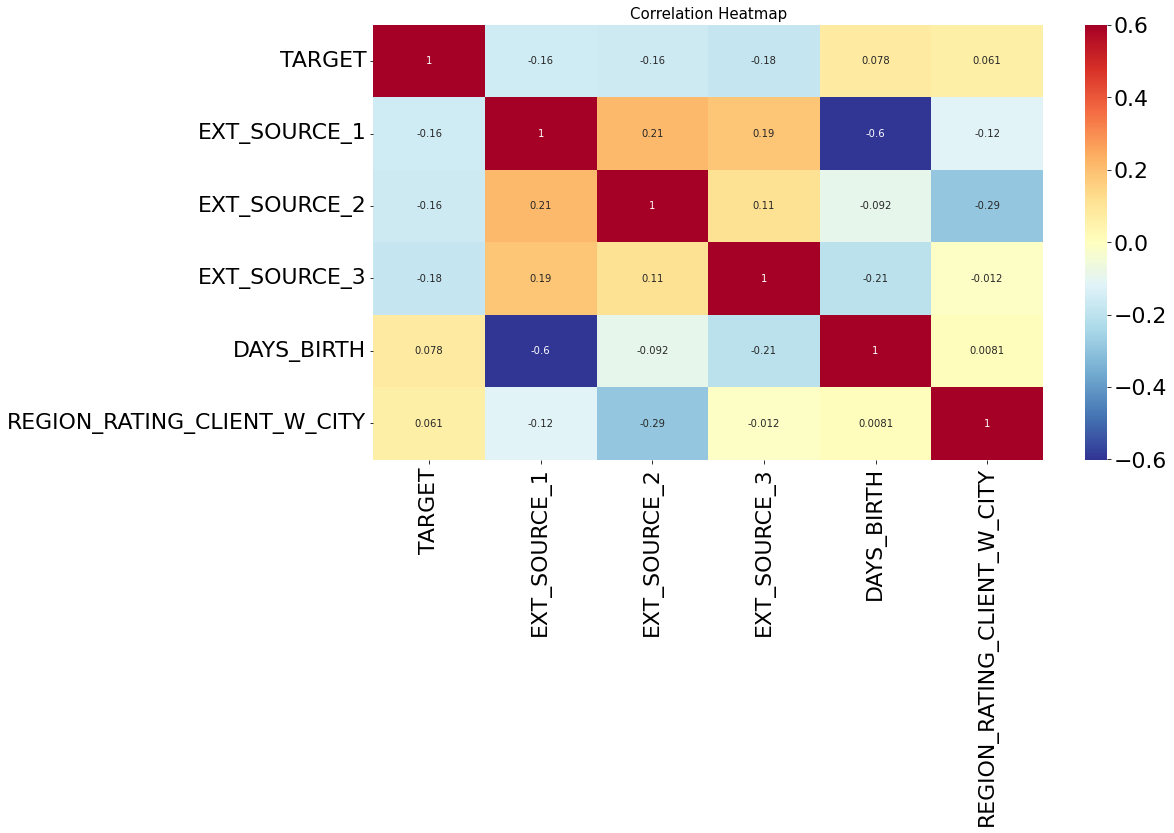

In [35]:
# extraction de var correlé > 0.05
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 
                      "REGION_RATING_CLIENT_W_CITY"]]
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (15, 8))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap', fontsize=15);

DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age

## Previous application data

In [31]:
previous_application["NAME_CONTRACT_STATUS"]

0          Approved
1          Approved
2          Approved
3          Approved
4           Refused
             ...   
1670209    Approved
1670210    Approved
1670211    Approved
1670212    Approved
1670213    Approved
Name: NAME_CONTRACT_STATUS, Length: 1670214, dtype: object

In [9]:
previous_application[previous_application["NAME_CONTRACT_TYPE"] == "Cash loans"]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670206,2459206,238591,Cash loans,19401.435,180000.0,243936.0,0.0,180000.0,TUESDAY,13,...,XNA,24.0,high,Cash Street: high,365243.0,-1802.0,-1112.0,-1112.0,-1100.0,0.0
1670207,1662353,443544,Cash loans,12607.875,112500.0,112500.0,0.0,112500.0,MONDAY,10,...,XNA,12.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
1670208,1556789,209732,Cash loans,22299.390,315000.0,436216.5,NaN,315000.0,THURSDAY,17,...,XNA,36.0,middle,Cash X-Sell: middle,365243.0,-1249.0,-199.0,-919.0,-912.0,1.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [4]:
list_cercle_previous=["NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE", "NAME_PORTFOLIO"]
Name_cercle_previous=["Type de contrat du demandeur", "Statut du contrat du demandeur", 
                      "Mode de paiement du demandeur",  "La demande précédente"]


ana_cercle(list_cercle_previous, Name_cercle_previous, "previous")

<Figure size 432x288 with 0 Axes>

## Nettoyage 

In [41]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [51]:
def nettoyage_simple(df):
    imputer = SimpleImputer(strategy='median')
    app_df = df.copy()
    
    for i in df.columns:
        if (df[i].dtype == 'float')  or (df[i].dtype == 'int'):
            app_df[i] = imputer.fit_transform(app_df.loc[:, [i]].values)
    
    return app_df

In [52]:
app_train=nettoyage_simple(application_train)
app_test=nettoyage_simple(application_test)

In [55]:
app_bureau_balance=nettoyage_simple(bureau_balance)
app_bureau=nettoyage_simple(bureau)
app_previous_application=nettoyage_simple(previous_application)
app_credit=nettoyage_simple(credit_card_balance)
app_POS_CASh=nettoyage_simple(POS_CASH_balance)
app_installments=nettoyage_simple(installments_payments)

In [54]:
app_train.to_csv('app_train.csv', encoding='utf-8',index=False)
app_test.to_csv('app_test.csv', encoding='utf-8',index=False)

In [56]:
app_installments.to_csv('app_installments.csv', encoding='utf-8',index=False)
app_POS_CASh.to_csv('app_POS_CASh.csv', encoding='utf-8',index=False)
app_credit.to_csv('app_credit.csv', encoding='utf-8',index=False)
app_previous_application.to_csv('app_previous_application.csv', encoding='utf-8',index=False)
app_bureau.to_csv('app_bureau.csv', encoding='utf-8',index=False)
app_bureau_balance.to_csv('app_bureau_balance.csv', encoding='utf-8',index=False)

In [59]:
ana_missing_data(app_credit)

,Total,Percent


In [3]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [21]:
print(len(bureau["SK_ID_BUREAU"].unique()))
print(bureau.shape)

1716428
(1716428, 17)


In [44]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [22]:
bureau_balance_encod, new_columns = one_hot_encoder(bureau_balance, nan_as_category = True)

In [23]:
bureau_balance_encod

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,STATUS_nan
0,5715448,0,0,0,0,0,0,0,1,0,0
1,5715448,-1,0,0,0,0,0,0,1,0,0
2,5715448,-2,0,0,0,0,0,0,1,0,0
3,5715448,-3,0,0,0,0,0,0,1,0,0
4,5715448,-4,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
27299920,5041336,-47,0,0,0,0,0,0,0,1,0
27299921,5041336,-48,0,0,0,0,0,0,0,1,0
27299922,5041336,-49,0,0,0,0,0,0,0,1,0
27299923,5041336,-50,0,0,0,0,0,0,0,1,0


In [18]:
def bureau_and_balance(bureau, bb):
    bb, bb_cat = one_hot_encoder(bb, nan_as_category = True)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category = True)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [19]:
bureau_aggre= bureau_and_balance(bureau, bureau_balance)

In [20]:
bureau_aggre

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0
